In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
from tqdm import tqdm

import tensorflow as tf

# <project_root>/ddnet/ddnet.py
sys.path.insert(0, os.path.join(os.path.abspath(''), '..', 'ddnet'))
import ddnet

Using TensorFlow backend.


# Initialize the setting

In [2]:
random.seed(123)

# directory that contains pickle files
undoctored_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose_tracking_pkl')
doctored_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose_tracking_doctored_pkl')

# Helper functions

In [3]:
def data_generator(T, C, le, exclude_labels=[], max_per_class=None):
    """
    Generate X (list of arrays) and Y (array) from a dict 
    """
    poses = []
    labels = []
    counter = collections.Counter()
    for p, L in zip(T['pose'], T['label']):
        if L not in exclude_labels and (max_per_class is None or counter[L] < max_per_class):
            poses.append(p)
            labels.append(L)
            counter[L] += 1
    
    X = poses # list of arrays
    Y = np.zeros(shape=(len(labels), C.clc_num)) # 2D array one-hot encoding of labels
    Y[range(Y.shape[0]), le.transform(labels)] = 1
    return X, Y

In [4]:
# helper functions for plotting
# history is a history object from keras
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

In [5]:
def count_all_nan(X):
    return sum([np.count_nonzero(np.isnan(x)) for x in X])

## Load and Preprocess Data

In [6]:
# Load pickle files
Train_undoctored = pickle.load(open(os.path.join(undoctored_data_dir, "GT_train_1.pkl"), "rb"))
Test_undoctored = pickle.load(open(os.path.join(undoctored_data_dir, "GT_test_1.pkl"), "rb"))

Train_doctored = pickle.load(open(os.path.join(doctored_data_dir, "GT_train_1.pkl"), "rb"))
Test_doctored = pickle.load(open(os.path.join(doctored_data_dir, "GT_test_1.pkl"), "rb"))


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train_undoctored['label'])
print("Classses: ", len(le.classes_), le.classes_)

Classses:  21 ['brush_hair' 'catch' 'clap' 'climb_stairs' 'golf' 'jump' 'kick_ball'
 'pick' 'pour' 'pullup' 'push' 'run' 'shoot_ball' 'shoot_bow' 'shoot_gun'
 'sit' 'stand' 'swing_baseball' 'throw' 'walk' 'wave']


In [7]:
# examine some known strange videos
print(Train_undoctored.keys())
for p, L, filename in zip(Train_undoctored['pose'], Train_undoctored['label'], Train_undoctored['filename']):
    if 'Maddin_winkt' in filename:
        print(L, filename)
        print(p.dtype)
        # print('Nose\n', p[:, 0, :])
        print('RElbow\n', p[:, 3, :])
        print('RWrist\n', p[:, 4, :])
        print('LElbow\n', p[:, 6, :])
        print('RWrist\n', p[:, 7, :])
        break

dict_keys(['pose', 'label', 'filename'])
wave wave/Maddin_winkt_wave_h_cm_np1_fr_med_1
float64
RElbow
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
RWrist
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
LElbow
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0

### Optionally Combine doctored and undoctored train/test

In [8]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=15, joint_dim=2, num_classes=21, num_filters=32)

X_doctored, Y_doctored = data_generator(Train_doctored,C,le)
X_undoctored, Y_undoctored = data_generator(Train_undoctored,C,le)

# print("Combine doctored and undoctored training sets!")
# X = X_doctored + X_undoctored
# Y = np.concatenate([Y_doctored, Y_undoctored])

X = X_undoctored
Y = Y_undoctored

# X = X_doctored
# Y = Y_doctored

X_test,Y_test = data_generator(Test_undoctored,C,le) #, exclude_labels=['climb_stairs', 'jump', 'kick_ball', 'run', 'sit', 'stand', 'walk'])

print(len(X), X[0].shape, Y.shape)
print(len(X_test), X_test[0].shape, Y_test.shape)

643 (30, 25, 2) (643, 21)
259 (31, 25, 2) (259, 21)


### Set values related to unknown joints to zeros in input

In [9]:
from ddnet import *

cleaner = ddnet.OpenPoseDataCleaner(copy=True, filter_joint_idx=None)

def per_video_normalize_2(p, copy=True):
    """
    For x,y[, z] independently:
        Normalize into between -0.5~0.5
    Use the same denorminator
    """
    q = p.copy() if copy else p
    W = np.nanmax(q[:, :, 0]) - np.nanmin(q[:, :, 0])
    for coord in range(p.shape[2]):
        view = q[:, :, coord]
        a, b = np.nanmin(view), np.nanmax(view)
        view[:] = ((view - a) / W) - 0.5

    return q


def temporal_interp_thres(p, copy=True, known_thres=.1):
    """
    If a joint is detected in at least one frame in a video, 
    we interpolate the nan coordinates from other frames.
    This is done independently for each joint.
    Note: it can still leave some all-nan columns if a joint is never detected in any frame.
    """
    q = p.copy() if copy else p

    for j in range(q.shape[1]): # joint
        for coord in range(q.shape[2]): # x, y (,z)
            view = q[:, j, coord]
            if np.count_nonzero(~np.isnan(view)) / view.size < known_thres or not np.isnan(view).any():
                continue
            nans, idx = nan_helper(view)
            view[nans]= np.interp(idx(nans), idx(~nans), view[~nans])
    return q


def f1(p):
    return temporal_interp_thres(cleaner.make_nan(p))

def f2(p):
    return per_video_normalize_2(cleaner.filter_joints(f1(p), ddnet.OP_HAND_PICKED_GOOD_JOINTS))

X_interp = list(map(f2, X))
X_test_interp = list(map(f2, X_test))

print(len(X_interp), X_interp[0].shape, Y.shape)
print(len(X_test_interp), X_test_interp[0].shape, Y_test.shape)

print(count_all_nan(X_interp))
print(count_all_nan(X_test_interp))

643 (30, 15, 2) (643, 21)
259 (31, 15, 2) (259, 21)
64622
24355


In [10]:

def norm_scale_nan(x):
    return (x-np.nanmean(x))/np.nanmean(x)


def get_CG_nan(p,C):
    """Compute the Joint Collection Distances (JCD, refer to the paper) of a group of frames
    and normalize them to 0 mean.
    
    Arguments:
        p {ndarray} -- size = (C.frame_l, C.num_joints, C.joints_dim)
        C {Config} -- [description]
    
    Returns:
        ndarray -- shape = (C.frame_l, C.fead_d) 
    """
    # return JCD of a point, normalized to 0 mean
    M = []
    n_joint = p.shape[1]
    iu = np.triu_indices(n_joint, 1, n_joint)
    for frame in p:
        # frame.shape (n_joint, 2)
        d_m = cdist(frame, frame, 'euclidean')
        # erase values related to nan joints
        for jid, jcoord in enumerate(frame):
            if np.isnan(jcoord[0]):
                d_m[jid, :] = np.nan
                d_m[:, jid] = np.nan
        d_m = d_m[iu] 
        M.append(d_m)
    M = np.stack(M) 
    M = norm_scale_nan(M)
    return M


def preprocess_point_nan(p, C):
    """Preprocess a single point (a clip)
    
    Arguments:
        p {ndarray} -- shape = (variable, C.joint_n, C.joint_d)
        C {DDNetConfig} -- A Config object

    Returns:
        ndarray, ndarray -- X0, X1 to input to the net
    """
    assert p.shape[1:] == (C.joint_n, C.joint_d)
    # warn: zoom will spread a nan to whole array
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    # interploate to the right number of frames
    assert p.shape == (C.frame_l, C.joint_n, C.joint_d)
    M = get_CG_nan(p, C)
    
    M[np.isnan(M)] = 0.
    p[np.isnan(p)] = 0.

    return M, p

In [11]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=X_interp[0].shape[1], joint_dim=2, num_classes=21, num_filters=64)

X_0, X_1 = ddnet.preprocess_batch(X_interp, C, preprocess_point_fn=preprocess_point_nan)
X_test_0, X_test_1 = ddnet.preprocess_batch(X_test_interp, C, preprocess_point_fn=preprocess_point_nan)
print(X_0[0].shape, X_1[0].shape)

print(count_all_nan(X_interp))
print(count_all_nan(X_test_interp))
print(count_all_nan(X_0), count_all_nan(X_1))
print(count_all_nan(X_test_0), count_all_nan(X_test_1))

(32, 105) (32, 15, 2)
63742
24175
0 0
0 0


In [12]:
Y_input = Y
Y_test_input = Y_test

In [13]:
# # # commit changes
# X_input, Y_input = X, Y
# X_test_input, Y_test_input = X_test, Y_test

### DDNet's preprocess and config

In [14]:
# # redefine config with new # of joints
# C = ddnet.DDNetConfig(frame_length=32, num_joints=X_input[0].shape[1], joint_dim=2, num_classes=21, num_filters=64)

# X_0, X_1 = ddnet.preprocess_batch(X_input, C)
# X_test_0, X_test_1 = ddnet.preprocess_batch(X_test_input, C)
# print(X_0[0].shape, X_1[0].shape)

# Train, Test 

### Reweight training samples

In [15]:
# rescale sample weight to balance classes
def get_sample_weight(Y):
    cls_ids = np.argmax(Y, axis=1)
    assert cls_ids.shape[0] == Y.shape[0]
    cls_histo = np.array([np.count_nonzero(cls_ids==i) for i in range(Y.shape[1])])
    cls_weight = np.max(cls_histo) / cls_histo # balanced
    print(cls_histo)
    print(cls_weight)
    sample_weight = cls_weight[cls_ids]
    assert sample_weight.shape[0] == Y.shape[0]
    return sample_weight

In [16]:
sample_weight = get_sample_weight(Y_input)
print(sample_weight.shape)
print(sample_weight[:10])

[27 34 31 28 30 25 25 24 39 39 30 28 25 37 39 25 25 39 34 29 30]
[1.44444444 1.14705882 1.25806452 1.39285714 1.3        1.56
 1.56       1.625      1.         1.         1.3        1.39285714
 1.56       1.05405405 1.         1.56       1.56       1.
 1.14705882 1.34482759 1.3       ]
(643,)
[1.56 1.56 1.56 1.56 1.56 1.56 1.56 1.56 1.56 1.56]


### Train and plot loss/accuracy

In [17]:
DD_Net = ddnet.create_DDNet(C)
# DD_Net.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [18]:
import keras
from keras import backend as K
from keras.optimizers import *

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)
K.set_session(sess)

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=1000,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=400,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )



Train on 643 samples, validate on 259 samples
Epoch 1/1000
643/643 [==============================] - 7s 11ms/step - loss: 4.8785 - accuracy: 0.0513 - val_loss: 3.0452 - val_accuracy: 0.0463
Epoch 2/1000
643/643 [==============================] - 0s 149us/step - loss: 4.5871 - accuracy: 0.0560 - val_loss: 3.0428 - val_accuracy: 0.0927
Epoch 3/1000
643/643 [==============================] - 0s 153us/step - loss: 4.3366 - accuracy: 0.0871 - val_loss: 3.0396 - val_accuracy: 0.0927
Epoch 4/1000
643/643 [==============================] - 0s 152us/step - loss: 4.1122 - accuracy: 0.0949 - val_loss: 3.0358 - val_accuracy: 0.0734
Epoch 5/1000
643/643 [==============================] - 0s 154us/step - loss: 3.9218 - accuracy: 0.1446 - val_loss: 3.0308 - val_accuracy: 0.0656
Epoch 6/1000
643/643 [==============================] - 0s 149us/step - loss: 3.8343 - accuracy: 0.1384 - val_loss: 3.0250 - val_accuracy: 0.1236
Epoch 7/1000
643/643 [==============================] - 0s 146us/step - loss: 

Epoch 55/1000
643/643 [==============================] - 0s 153us/step - loss: 0.9026 - accuracy: 0.8289 - val_loss: 2.6863 - val_accuracy: 0.1699
Epoch 56/1000
643/643 [==============================] - 0s 148us/step - loss: 0.8926 - accuracy: 0.8289 - val_loss: 2.6819 - val_accuracy: 0.1660
Epoch 57/1000
643/643 [==============================] - 0s 151us/step - loss: 0.8784 - accuracy: 0.8305 - val_loss: 2.6742 - val_accuracy: 0.1699
Epoch 58/1000
643/643 [==============================] - 0s 148us/step - loss: 0.8743 - accuracy: 0.8414 - val_loss: 2.6586 - val_accuracy: 0.1583
Epoch 59/1000
643/643 [==============================] - 0s 153us/step - loss: 0.8689 - accuracy: 0.8243 - val_loss: 2.6451 - val_accuracy: 0.1815
Epoch 60/1000
643/643 [==============================] - 0s 137us/step - loss: 0.8095 - accuracy: 0.8429 - val_loss: 2.6379 - val_accuracy: 0.1892
Epoch 61/1000
643/643 [==============================] - 0s 144us/step - loss: 0.8075 - accuracy: 0.8351 - val_loss: 2

Epoch 111/1000
643/643 [==============================] - 0s 152us/step - loss: 0.1809 - accuracy: 0.9891 - val_loss: 3.0211 - val_accuracy: 0.1931
Epoch 112/1000
643/643 [==============================] - 0s 153us/step - loss: 0.1930 - accuracy: 0.9860 - val_loss: 3.0581 - val_accuracy: 0.1969
Epoch 113/1000
643/643 [==============================] - 0s 151us/step - loss: 0.2195 - accuracy: 0.9798 - val_loss: 3.0848 - val_accuracy: 0.1969
Epoch 114/1000
643/643 [==============================] - 0s 149us/step - loss: 0.1863 - accuracy: 0.9860 - val_loss: 3.1211 - val_accuracy: 0.2008
Epoch 115/1000
643/643 [==============================] - 0s 146us/step - loss: 0.1809 - accuracy: 0.9798 - val_loss: 3.1668 - val_accuracy: 0.1892
Epoch 116/1000
643/643 [==============================] - 0s 150us/step - loss: 0.1771 - accuracy: 0.9891 - val_loss: 3.1903 - val_accuracy: 0.1892
Epoch 117/1000
643/643 [==============================] - 0s 144us/step - loss: 0.1890 - accuracy: 0.9829 - val_

Epoch 167/1000
643/643 [==============================] - 0s 147us/step - loss: 0.0802 - accuracy: 0.9969 - val_loss: 3.2041 - val_accuracy: 0.2741
Epoch 168/1000
643/643 [==============================] - 0s 148us/step - loss: 0.0963 - accuracy: 0.9953 - val_loss: 3.2051 - val_accuracy: 0.2741
Epoch 169/1000
643/643 [==============================] - 0s 160us/step - loss: 0.1109 - accuracy: 0.9907 - val_loss: 3.2065 - val_accuracy: 0.2741
Epoch 170/1000
643/643 [==============================] - 0s 154us/step - loss: 0.1131 - accuracy: 0.9922 - val_loss: 3.2067 - val_accuracy: 0.2741
Epoch 171/1000
643/643 [==============================] - 0s 145us/step - loss: 0.1081 - accuracy: 0.9907 - val_loss: 3.2045 - val_accuracy: 0.2780
Epoch 172/1000
643/643 [==============================] - 0s 154us/step - loss: 0.1189 - accuracy: 0.9876 - val_loss: 3.2011 - val_accuracy: 0.2780
Epoch 173/1000
643/643 [==============================] - 0s 153us/step - loss: 0.0958 - accuracy: 0.9907 - val_

Epoch 223/1000
643/643 [==============================] - 0s 149us/step - loss: 0.0919 - accuracy: 0.9953 - val_loss: 2.9782 - val_accuracy: 0.3359
Epoch 224/1000
643/643 [==============================] - 0s 152us/step - loss: 0.0988 - accuracy: 0.9953 - val_loss: 2.9726 - val_accuracy: 0.3359
Epoch 225/1000
643/643 [==============================] - 0s 152us/step - loss: 0.0861 - accuracy: 0.9953 - val_loss: 2.9674 - val_accuracy: 0.3359
Epoch 226/1000
643/643 [==============================] - 0s 151us/step - loss: 0.0918 - accuracy: 0.9938 - val_loss: 2.9617 - val_accuracy: 0.3359
Epoch 227/1000
643/643 [==============================] - 0s 152us/step - loss: 0.0954 - accuracy: 0.9953 - val_loss: 2.9566 - val_accuracy: 0.3359
Epoch 228/1000
643/643 [==============================] - 0s 157us/step - loss: 0.0890 - accuracy: 0.9984 - val_loss: 2.9511 - val_accuracy: 0.3398
Epoch 229/1000
643/643 [==============================] - 0s 149us/step - loss: 0.0813 - accuracy: 1.0000 - val_

Epoch 334/1000
643/643 [==============================] - 0s 141us/step - loss: 0.0833 - accuracy: 1.0000 - val_loss: 2.3584 - val_accuracy: 0.4556
Epoch 335/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0956 - accuracy: 0.9953 - val_loss: 2.3528 - val_accuracy: 0.4595
Epoch 336/1000
643/643 [==============================] - 0s 148us/step - loss: 0.0739 - accuracy: 0.9984 - val_loss: 2.3476 - val_accuracy: 0.4595
Epoch 337/1000
643/643 [==============================] - 0s 140us/step - loss: 0.0920 - accuracy: 0.9953 - val_loss: 2.3422 - val_accuracy: 0.4595
Epoch 338/1000
643/643 [==============================] - 0s 143us/step - loss: 0.0850 - accuracy: 0.9953 - val_loss: 2.3364 - val_accuracy: 0.4595
Epoch 339/1000
643/643 [==============================] - 0s 143us/step - loss: 0.0843 - accuracy: 0.9969 - val_loss: 2.3311 - val_accuracy: 0.4595
Epoch 340/1000
643/643 [==============================] - 0s 143us/step - loss: 0.0967 - accuracy: 0.9938 - val_

Epoch 390/1000
643/643 [==============================] - 0s 140us/step - loss: 0.0931 - accuracy: 0.9938 - val_loss: 2.0875 - val_accuracy: 0.4749
Epoch 391/1000
643/643 [==============================] - 0s 141us/step - loss: 0.0920 - accuracy: 0.9953 - val_loss: 2.0836 - val_accuracy: 0.4749
Epoch 392/1000
643/643 [==============================] - 0s 139us/step - loss: 0.0806 - accuracy: 1.0000 - val_loss: 2.0797 - val_accuracy: 0.4749
Epoch 393/1000
643/643 [==============================] - 0s 149us/step - loss: 0.1079 - accuracy: 0.9907 - val_loss: 2.0758 - val_accuracy: 0.4749
Epoch 394/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0803 - accuracy: 0.9984 - val_loss: 2.0716 - val_accuracy: 0.4749
Epoch 395/1000
643/643 [==============================] - 0s 143us/step - loss: 0.0971 - accuracy: 0.9907 - val_loss: 2.0678 - val_accuracy: 0.4865
Epoch 396/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0982 - accuracy: 0.9969 - val_

Epoch 446/1000
643/643 [==============================] - 0s 136us/step - loss: 0.0950 - accuracy: 0.9969 - val_loss: 1.8727 - val_accuracy: 0.5328
Epoch 447/1000
643/643 [==============================] - 0s 136us/step - loss: 0.0917 - accuracy: 0.9938 - val_loss: 1.8692 - val_accuracy: 0.5367
Epoch 448/1000
643/643 [==============================] - 0s 136us/step - loss: 0.0834 - accuracy: 0.9938 - val_loss: 1.8660 - val_accuracy: 0.5367
Epoch 449/1000
643/643 [==============================] - 0s 134us/step - loss: 0.0853 - accuracy: 0.9953 - val_loss: 1.8626 - val_accuracy: 0.5405
Epoch 450/1000
643/643 [==============================] - 0s 136us/step - loss: 0.0988 - accuracy: 0.9891 - val_loss: 1.8593 - val_accuracy: 0.5405
Epoch 451/1000
643/643 [==============================] - 0s 131us/step - loss: 0.0920 - accuracy: 0.9938 - val_loss: 1.8559 - val_accuracy: 0.5405
Epoch 452/1000
643/643 [==============================] - 0s 134us/step - loss: 0.0830 - accuracy: 0.9969 - val_

Epoch 502/1000
643/643 [==============================] - 0s 139us/step - loss: 0.0874 - accuracy: 0.9984 - val_loss: 1.7172 - val_accuracy: 0.5714
Epoch 503/1000
643/643 [==============================] - 0s 144us/step - loss: 0.0763 - accuracy: 0.9953 - val_loss: 1.7148 - val_accuracy: 0.5792
Epoch 504/1000
643/643 [==============================] - 0s 144us/step - loss: 0.0830 - accuracy: 0.9953 - val_loss: 1.7121 - val_accuracy: 0.5792
Epoch 505/1000
643/643 [==============================] - 0s 145us/step - loss: 0.0757 - accuracy: 0.9984 - val_loss: 1.7096 - val_accuracy: 0.5792
Epoch 506/1000
643/643 [==============================] - 0s 145us/step - loss: 0.0809 - accuracy: 0.9953 - val_loss: 1.7070 - val_accuracy: 0.5792
Epoch 507/1000
643/643 [==============================] - 0s 141us/step - loss: 0.0915 - accuracy: 0.9938 - val_loss: 1.7046 - val_accuracy: 0.5792
Epoch 508/1000
643/643 [==============================] - 0s 136us/step - loss: 0.1092 - accuracy: 0.9860 - val_

Epoch 558/1000
643/643 [==============================] - 0s 129us/step - loss: 0.0791 - accuracy: 0.9969 - val_loss: 1.5960 - val_accuracy: 0.6100
Epoch 559/1000
643/643 [==============================] - 0s 134us/step - loss: 0.0804 - accuracy: 0.9938 - val_loss: 1.5943 - val_accuracy: 0.6100
Epoch 560/1000
643/643 [==============================] - 0s 150us/step - loss: 0.0849 - accuracy: 0.9984 - val_loss: 1.5925 - val_accuracy: 0.6100
Epoch 561/1000
643/643 [==============================] - 0s 150us/step - loss: 0.0827 - accuracy: 0.9938 - val_loss: 1.5908 - val_accuracy: 0.6100
Epoch 562/1000
643/643 [==============================] - 0s 147us/step - loss: 0.0766 - accuracy: 0.9984 - val_loss: 1.5890 - val_accuracy: 0.6100
Epoch 563/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0788 - accuracy: 0.9953 - val_loss: 1.5874 - val_accuracy: 0.6100
Epoch 564/1000
643/643 [==============================] - 0s 138us/step - loss: 0.0748 - accuracy: 0.9953 - val_

Epoch 614/1000
643/643 [==============================] - 0s 145us/step - loss: 0.0730 - accuracy: 0.9984 - val_loss: 1.5246 - val_accuracy: 0.6255
Epoch 615/1000
643/643 [==============================] - 0s 147us/step - loss: 0.0795 - accuracy: 0.9984 - val_loss: 1.5235 - val_accuracy: 0.6255
Epoch 616/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0768 - accuracy: 0.9969 - val_loss: 1.5225 - val_accuracy: 0.6255
Epoch 617/1000
643/643 [==============================] - 0s 141us/step - loss: 0.0845 - accuracy: 0.9969 - val_loss: 1.5213 - val_accuracy: 0.6293
Epoch 618/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0840 - accuracy: 0.9938 - val_loss: 1.5202 - val_accuracy: 0.6293
Epoch 619/1000
643/643 [==============================] - 0s 140us/step - loss: 0.0779 - accuracy: 0.9953 - val_loss: 1.5189 - val_accuracy: 0.6293
Epoch 620/1000
643/643 [==============================] - 0s 132us/step - loss: 0.0935 - accuracy: 0.9953 - val_

Epoch 670/1000
643/643 [==============================] - 0s 142us/step - loss: 0.0824 - accuracy: 0.9953 - val_loss: 1.4809 - val_accuracy: 0.6332
Epoch 671/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0866 - accuracy: 0.9984 - val_loss: 1.4803 - val_accuracy: 0.6371
Epoch 672/1000
643/643 [==============================] - 0s 143us/step - loss: 0.0851 - accuracy: 0.9953 - val_loss: 1.4797 - val_accuracy: 0.6371
Epoch 673/1000
643/643 [==============================] - 0s 144us/step - loss: 0.0752 - accuracy: 0.9984 - val_loss: 1.4791 - val_accuracy: 0.6371
Epoch 674/1000
643/643 [==============================] - 0s 143us/step - loss: 0.0846 - accuracy: 0.9938 - val_loss: 1.4784 - val_accuracy: 0.6371
Epoch 675/1000
643/643 [==============================] - 0s 144us/step - loss: 0.0881 - accuracy: 0.9938 - val_loss: 1.4781 - val_accuracy: 0.6371
Epoch 676/1000
643/643 [==============================] - 0s 144us/step - loss: 0.0911 - accuracy: 0.9938 - val_

Epoch 726/1000
643/643 [==============================] - 0s 142us/step - loss: 0.0982 - accuracy: 0.9922 - val_loss: 1.4712 - val_accuracy: 0.6409
Epoch 727/1000
643/643 [==============================] - 0s 143us/step - loss: 0.0752 - accuracy: 0.9953 - val_loss: 1.4710 - val_accuracy: 0.6409
Epoch 728/1000
643/643 [==============================] - 0s 135us/step - loss: 0.0885 - accuracy: 0.9907 - val_loss: 1.4707 - val_accuracy: 0.6409
Epoch 729/1000
643/643 [==============================] - 0s 138us/step - loss: 0.0883 - accuracy: 0.9953 - val_loss: 1.4707 - val_accuracy: 0.6409
Epoch 730/1000
643/643 [==============================] - 0s 133us/step - loss: 0.0793 - accuracy: 0.9984 - val_loss: 1.4704 - val_accuracy: 0.6409
Epoch 731/1000
643/643 [==============================] - 0s 137us/step - loss: 0.0824 - accuracy: 0.9953 - val_loss: 1.4701 - val_accuracy: 0.6409
Epoch 732/1000
643/643 [==============================] - 0s 150us/step - loss: 0.0859 - accuracy: 0.9969 - val_

Epoch 782/1000
643/643 [==============================] - 0s 159us/step - loss: 0.0914 - accuracy: 0.9876 - val_loss: 1.4589 - val_accuracy: 0.6293
Epoch 783/1000
643/643 [==============================] - 0s 147us/step - loss: 0.0840 - accuracy: 0.9953 - val_loss: 1.4584 - val_accuracy: 0.6371
Epoch 784/1000
643/643 [==============================] - 0s 141us/step - loss: 0.0914 - accuracy: 0.9984 - val_loss: 1.4580 - val_accuracy: 0.6371
Epoch 785/1000
643/643 [==============================] - 0s 151us/step - loss: 0.0783 - accuracy: 0.9922 - val_loss: 1.4575 - val_accuracy: 0.6371
Epoch 786/1000
643/643 [==============================] - 0s 143us/step - loss: 0.0827 - accuracy: 0.9984 - val_loss: 1.4571 - val_accuracy: 0.6371
Epoch 787/1000
643/643 [==============================] - 0s 145us/step - loss: 0.0703 - accuracy: 1.0000 - val_loss: 1.4567 - val_accuracy: 0.6371
Epoch 788/1000
643/643 [==============================] - 0s 139us/step - loss: 0.0735 - accuracy: 0.9984 - val_

Epoch 838/1000
643/643 [==============================] - 0s 136us/step - loss: 0.0733 - accuracy: 0.9969 - val_loss: 1.4528 - val_accuracy: 0.6525
Epoch 839/1000
643/643 [==============================] - 0s 158us/step - loss: 0.0978 - accuracy: 0.9938 - val_loss: 1.4528 - val_accuracy: 0.6525
Epoch 840/1000
643/643 [==============================] - 0s 152us/step - loss: 0.0672 - accuracy: 0.9984 - val_loss: 1.4529 - val_accuracy: 0.6525
Epoch 841/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0806 - accuracy: 0.9969 - val_loss: 1.4530 - val_accuracy: 0.6525
Epoch 842/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0732 - accuracy: 0.9969 - val_loss: 1.4532 - val_accuracy: 0.6525
Epoch 843/1000
643/643 [==============================] - 0s 144us/step - loss: 0.0792 - accuracy: 0.9984 - val_loss: 1.4534 - val_accuracy: 0.6525
Epoch 844/1000
643/643 [==============================] - 0s 145us/step - loss: 0.0798 - accuracy: 0.9938 - val_

Epoch 894/1000
643/643 [==============================] - 0s 142us/step - loss: 0.0709 - accuracy: 0.9984 - val_loss: 1.4564 - val_accuracy: 0.6486
Epoch 895/1000
643/643 [==============================] - 0s 147us/step - loss: 0.0805 - accuracy: 0.9953 - val_loss: 1.4561 - val_accuracy: 0.6486
Epoch 896/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0581 - accuracy: 1.0000 - val_loss: 1.4559 - val_accuracy: 0.6486
Epoch 897/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0790 - accuracy: 0.9953 - val_loss: 1.4558 - val_accuracy: 0.6486
Epoch 898/1000
643/643 [==============================] - 0s 147us/step - loss: 0.0886 - accuracy: 0.9938 - val_loss: 1.4559 - val_accuracy: 0.6486
Epoch 899/1000
643/643 [==============================] - 0s 144us/step - loss: 0.0790 - accuracy: 0.9953 - val_loss: 1.4556 - val_accuracy: 0.6486
Epoch 900/1000
643/643 [==============================] - 0s 145us/step - loss: 0.0817 - accuracy: 0.9953 - val_

Epoch 950/1000
643/643 [==============================] - 0s 149us/step - loss: 0.0785 - accuracy: 0.9953 - val_loss: 1.4598 - val_accuracy: 0.6486
Epoch 951/1000
643/643 [==============================] - 0s 150us/step - loss: 0.0974 - accuracy: 0.9891 - val_loss: 1.4597 - val_accuracy: 0.6486
Epoch 952/1000
643/643 [==============================] - 0s 152us/step - loss: 0.0774 - accuracy: 0.9969 - val_loss: 1.4597 - val_accuracy: 0.6486
Epoch 953/1000
643/643 [==============================] - 0s 146us/step - loss: 0.0767 - accuracy: 0.9969 - val_loss: 1.4595 - val_accuracy: 0.6486
Epoch 954/1000
643/643 [==============================] - 0s 147us/step - loss: 0.0848 - accuracy: 0.9922 - val_loss: 1.4594 - val_accuracy: 0.6486
Epoch 955/1000
643/643 [==============================] - 0s 139us/step - loss: 0.0844 - accuracy: 0.9969 - val_loss: 1.4594 - val_accuracy: 0.6525
Epoch 956/1000
643/643 [==============================] - 0s 151us/step - loss: 0.0881 - accuracy: 0.9953 - val_

Epoch 6/400
643/643 [==============================] - 0s 136us/step - loss: 0.0808 - accuracy: 0.9938 - val_loss: 1.4683 - val_accuracy: 0.6371
Epoch 7/400
643/643 [==============================] - 0s 136us/step - loss: 0.0842 - accuracy: 0.9938 - val_loss: 1.4728 - val_accuracy: 0.6332
Epoch 8/400
643/643 [==============================] - 0s 137us/step - loss: 0.0754 - accuracy: 1.0000 - val_loss: 1.4782 - val_accuracy: 0.6486
Epoch 9/400
643/643 [==============================] - 0s 140us/step - loss: 0.0922 - accuracy: 0.9891 - val_loss: 1.4808 - val_accuracy: 0.6371
Epoch 10/400
643/643 [==============================] - 0s 133us/step - loss: 0.0824 - accuracy: 0.9938 - val_loss: 1.4810 - val_accuracy: 0.6332
Epoch 11/400
643/643 [==============================] - 0s 133us/step - loss: 0.0740 - accuracy: 0.9938 - val_loss: 1.4812 - val_accuracy: 0.6332
Epoch 12/400
643/643 [==============================] - 0s 134us/step - loss: 0.0792 - accuracy: 0.9969 - val_loss: 1.4802 - val

Epoch 63/400
643/643 [==============================] - 0s 142us/step - loss: 0.0688 - accuracy: 0.9953 - val_loss: 1.4932 - val_accuracy: 0.6409
Epoch 64/400
643/643 [==============================] - 0s 142us/step - loss: 0.0580 - accuracy: 1.0000 - val_loss: 1.4930 - val_accuracy: 0.6409
Epoch 65/400
643/643 [==============================] - 0s 134us/step - loss: 0.0696 - accuracy: 0.9969 - val_loss: 1.4929 - val_accuracy: 0.6409
Epoch 66/400
643/643 [==============================] - 0s 151us/step - loss: 0.0834 - accuracy: 0.9922 - val_loss: 1.4928 - val_accuracy: 0.6409
Epoch 67/400
643/643 [==============================] - 0s 136us/step - loss: 0.0695 - accuracy: 0.9969 - val_loss: 1.4927 - val_accuracy: 0.6409
Epoch 68/400
643/643 [==============================] - 0s 156us/step - loss: 0.0695 - accuracy: 0.9969 - val_loss: 1.4923 - val_accuracy: 0.6409
Epoch 69/400
643/643 [==============================] - 0s 138us/step - loss: 0.0776 - accuracy: 0.9953 - val_loss: 1.4921 -

Epoch 119/400
643/643 [==============================] - 0s 127us/step - loss: 0.0647 - accuracy: 0.9969 - val_loss: 1.4910 - val_accuracy: 0.6448
Epoch 120/400
643/643 [==============================] - 0s 130us/step - loss: 0.0603 - accuracy: 1.0000 - val_loss: 1.4910 - val_accuracy: 0.6448
Epoch 121/400
643/643 [==============================] - 0s 131us/step - loss: 0.0715 - accuracy: 0.9969 - val_loss: 1.4911 - val_accuracy: 0.6448
Epoch 122/400
643/643 [==============================] - 0s 125us/step - loss: 0.0584 - accuracy: 0.9984 - val_loss: 1.4912 - val_accuracy: 0.6448
Epoch 123/400
643/643 [==============================] - 0s 131us/step - loss: 0.0703 - accuracy: 0.9953 - val_loss: 1.4913 - val_accuracy: 0.6448
Epoch 124/400
643/643 [==============================] - 0s 130us/step - loss: 0.0759 - accuracy: 0.9907 - val_loss: 1.4915 - val_accuracy: 0.6448
Epoch 125/400
643/643 [==============================] - 0s 134us/step - loss: 0.0711 - accuracy: 0.9907 - val_loss: 1

Epoch 175/400
643/643 [==============================] - 0s 137us/step - loss: 0.0765 - accuracy: 0.9938 - val_loss: 1.4899 - val_accuracy: 0.6448
Epoch 176/400
643/643 [==============================] - 0s 137us/step - loss: 0.0751 - accuracy: 0.9984 - val_loss: 1.4898 - val_accuracy: 0.6448
Epoch 177/400
643/643 [==============================] - 0s 132us/step - loss: 0.0648 - accuracy: 0.9984 - val_loss: 1.4898 - val_accuracy: 0.6448
Epoch 178/400
643/643 [==============================] - 0s 137us/step - loss: 0.0676 - accuracy: 0.9969 - val_loss: 1.4898 - val_accuracy: 0.6448
Epoch 179/400
643/643 [==============================] - 0s 136us/step - loss: 0.0775 - accuracy: 0.9969 - val_loss: 1.4895 - val_accuracy: 0.6448
Epoch 180/400
643/643 [==============================] - 0s 135us/step - loss: 0.0803 - accuracy: 0.9938 - val_loss: 1.4894 - val_accuracy: 0.6448
Epoch 181/400
643/643 [==============================] - 0s 136us/step - loss: 0.0663 - accuracy: 0.9984 - val_loss: 1

Epoch 231/400
643/643 [==============================] - 0s 130us/step - loss: 0.0535 - accuracy: 1.0000 - val_loss: 1.4916 - val_accuracy: 0.6371
Epoch 232/400
643/643 [==============================] - 0s 132us/step - loss: 0.0736 - accuracy: 0.9984 - val_loss: 1.4916 - val_accuracy: 0.6409
Epoch 233/400
643/643 [==============================] - 0s 134us/step - loss: 0.0748 - accuracy: 0.9953 - val_loss: 1.4914 - val_accuracy: 0.6409
Epoch 234/400
643/643 [==============================] - 0s 133us/step - loss: 0.0838 - accuracy: 0.9922 - val_loss: 1.4912 - val_accuracy: 0.6409
Epoch 235/400
643/643 [==============================] - 0s 133us/step - loss: 0.0593 - accuracy: 0.9984 - val_loss: 1.4909 - val_accuracy: 0.6409
Epoch 236/400
643/643 [==============================] - 0s 136us/step - loss: 0.0883 - accuracy: 0.9922 - val_loss: 1.4907 - val_accuracy: 0.6409
Epoch 237/400
643/643 [==============================] - 0s 140us/step - loss: 0.0737 - accuracy: 0.9969 - val_loss: 1

Epoch 287/400
643/643 [==============================] - 0s 139us/step - loss: 0.0769 - accuracy: 1.0000 - val_loss: 1.4870 - val_accuracy: 0.6332
Epoch 288/400
643/643 [==============================] - 0s 125us/step - loss: 0.0677 - accuracy: 0.9984 - val_loss: 1.4870 - val_accuracy: 0.6332
Epoch 289/400
643/643 [==============================] - 0s 128us/step - loss: 0.0693 - accuracy: 0.9953 - val_loss: 1.4870 - val_accuracy: 0.6332
Epoch 290/400
643/643 [==============================] - 0s 128us/step - loss: 0.0662 - accuracy: 0.9969 - val_loss: 1.4871 - val_accuracy: 0.6332
Epoch 291/400
643/643 [==============================] - 0s 134us/step - loss: 0.0763 - accuracy: 0.9938 - val_loss: 1.4871 - val_accuracy: 0.6332
Epoch 292/400
643/643 [==============================] - 0s 129us/step - loss: 0.0584 - accuracy: 0.9969 - val_loss: 1.4871 - val_accuracy: 0.6332
Epoch 293/400
643/643 [==============================] - 0s 131us/step - loss: 0.0662 - accuracy: 0.9953 - val_loss: 1

Epoch 343/400
643/643 [==============================] - 0s 142us/step - loss: 0.0788 - accuracy: 0.9969 - val_loss: 1.4869 - val_accuracy: 0.6332
Epoch 344/400
643/643 [==============================] - 0s 140us/step - loss: 0.0684 - accuracy: 0.9953 - val_loss: 1.4866 - val_accuracy: 0.6332
Epoch 345/400
643/643 [==============================] - 0s 141us/step - loss: 0.0819 - accuracy: 0.9907 - val_loss: 1.4864 - val_accuracy: 0.6332
Epoch 346/400
643/643 [==============================] - 0s 135us/step - loss: 0.0646 - accuracy: 0.9938 - val_loss: 1.4862 - val_accuracy: 0.6332
Epoch 347/400
643/643 [==============================] - 0s 137us/step - loss: 0.0639 - accuracy: 1.0000 - val_loss: 1.4861 - val_accuracy: 0.6332
Epoch 348/400
643/643 [==============================] - 0s 141us/step - loss: 0.0695 - accuracy: 0.9922 - val_loss: 1.4860 - val_accuracy: 0.6332
Epoch 349/400
643/643 [==============================] - 0s 151us/step - loss: 0.0702 - accuracy: 0.9953 - val_loss: 1

Epoch 399/400
643/643 [==============================] - 0s 137us/step - loss: 0.0566 - accuracy: 0.9969 - val_loss: 1.4882 - val_accuracy: 0.6332
Epoch 400/400
643/643 [==============================] - 0s 133us/step - loss: 0.0655 - accuracy: 0.9969 - val_loss: 1.4886 - val_accuracy: 0.6332


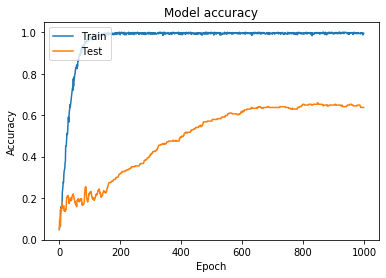

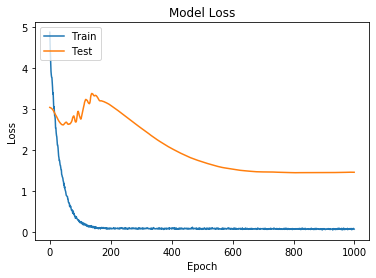

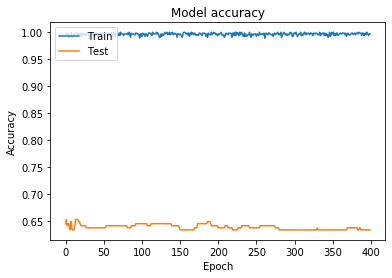

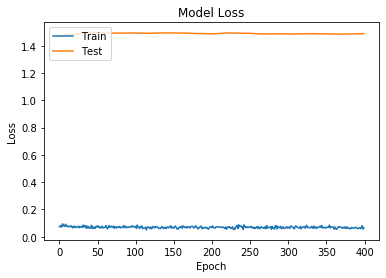

In [19]:
%matplotlib inline
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Plot confusion matrix

In [20]:
Y_test_pred = DD_Net.predict([X_test_0, X_test_1])

[[ 3  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  2]
 [ 0  5  0  0  0  0  0  0  0  0  1  0  1  0  3  0  0  0  2  0  0]
 [ 1  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  8  0  0  3  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  3  0  1  0  0  0  0  1  0  0  2  2  0  1  0  0]
 [ 0  0  0  1  0  1  2  0  0  1  0  4  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  1  0  0  1  8  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0 11  0  0  0  0  1  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  7  0  0  0  1  0  0  0  1  1  0]
 [ 0  0  0  5  0  0  2  0  0  0  0  2  0  0  0  1  0  0  0  1  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  8  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0 12  0  0  0  0  1  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  1  0  0  1 12  0  0  0  0  1  0]
 [ 0  0  0

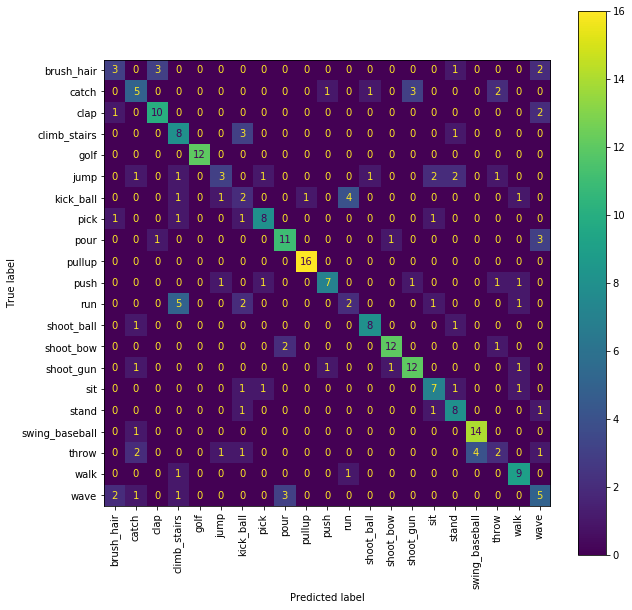

In [21]:
Y_test_pred_cls = np.argmax(Y_test_pred, axis=1)
Y_test_cls = np.argmax(Y_test_input, axis=1)
Y_test_cls[:10], Y_test_pred_cls[:10]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
normalize= None # 'true'
cm = confusion_matrix(Y_test_cls, Y_test_pred_cls, normalize=normalize)
print(cm)
# print(np.sum(np.diagonal(cm)) / np.sum(cm)) # accuracy

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_) #sorted(set(le.inverse_transform(Y_test_cls))))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=90, ax=ax)

In [22]:
# other statistics
import pandas as pd
from sklearn.metrics import average_precision_score

df = pd.DataFrame()

for i, cls_name in enumerate(le.classes_):
    precision = np.round(cm[i, i] / np.sum(cm[:, i]), 2)
    recall = np.round(cm[i, i] / np.sum(cm[i, :]), 2)
    train_size =  list(le.inverse_transform(np.argmax(Y_input, axis=1))).count(cls_name)
    test_size =  list(le.inverse_transform(np.argmax(Y_test_input, axis=1))).count(cls_name)

    ap = average_precision_score(Y_test_input[:, i], Y_test_pred[:, i])
        
    df = df.append({
        'class_name': cls_name,
        'precision': precision,
        'recall': recall,
        'train_size': train_size,
        'test_size': test_size,
        '1-vs-all AP': ap 
    }, ignore_index=True)

print(df.round(3))

    1-vs-all AP      class_name  precision  recall  test_size  train_size
0         0.325      brush_hair       0.43    0.33        9.0        27.0
1         0.421           catch       0.42    0.42       12.0        34.0
2         0.845            clap       0.71    0.77       13.0        31.0
3         0.457    climb_stairs       0.44    0.67       12.0        28.0
4         1.000            golf       1.00    1.00       12.0        30.0
5         0.300            jump       0.50    0.25       12.0        25.0
6         0.301       kick_ball       0.18    0.20       10.0        25.0
7         0.735            pick       0.73    0.67       12.0        24.0
8         0.778            pour       0.69    0.69       16.0        39.0
9         1.000          pullup       0.94    1.00       16.0        39.0
10        0.603            push       0.78    0.58       12.0        30.0
11        0.281             run       0.29    0.18       11.0        28.0
12        0.933      shoot_ball       

### Eval on doctored test set

In [ ]:
# quick evaluate on doctored test set

X_test_d,Y_test_d = data_generator(Test_doctored,C,le)
X_test_d, Y_test_d =  cleaner.augment_XY(X_test_d, Y_test_d, factor=5)
print(len(X_test_d), Y_test_d.shape)
DD_Net.evaluate(list(ddnet.preprocess_batch(X_test_d, C)), Y_test_d)

# DD_Net.evaluate([X_test_0,X_test_1], Y_test_input)

### Save model to disk

In [ ]:
model_path = 'jhmdb_openpose_model_upper_10.h5'
ddnet.save_DDNet(DD_Net, model_path)

### Examine wrong predictions

In [35]:
def check_labels(Y_true, Y_pred, le, filenames, labels=['wave']):
    assert Y_true.shape[0] == Y_pred.shape[0] == len(filenames)
    for yt, yp, fn in zip(Y_true, Y_pred, filenames):
        cls_true = np.argmax(yt)
        cls_pred = np.argmax(yp)
        if le.inverse_transform([cls_true])[0] in labels:
            correct = (cls_true == cls_pred)
            print("{} \t{}={:.2f} \t{}={:.2f} \t{}".format(
                correct,
                le.inverse_transform([cls_pred])[0],
                np.max(yp),
                labels[0],
                yp[cls_true],
                fn
            ))
            
check_labels(Y_test_input, Y_test_pred, le, Test_undoctored['filename'])

False 	pour=1.00 	wave=0.00 	wave/Chris_Benoit_waving_goodbye_wave_u_nm_np1_fr_med_0
True 	wave=0.51 	wave=0.51 	wave/Maya_beim_Winken_wave_f_cm_np1_fr_med_0
True 	wave=0.99 	wave=0.99 	wave/BIG_FISH_wave_u_nm_np1_fr_goo_9
False 	pour=0.99 	wave=0.00 	wave/Chris_Benoit_waving_goodbye_wave_u_nm_np1_fr_med_1
False 	brush_hair=0.99 	wave=0.00 	wave/WeddingCrashers_wave_u_nm_np1_fr_goo_0
False 	brush_hair=0.98 	wave=0.00 	wave/50_FIRST_DATES_wave_u_cm_np1_fr_goo_30
True 	wave=0.82 	wave=0.82 	wave/Maya_beim_Winken_wave_f_cm_np1_fr_med_2
False 	catch=0.56 	wave=0.01 	wave/Maya_beim_Winken_wave_f_cm_np1_fr_med_1
False 	climb_stairs=0.42 	wave=0.01 	wave/20060723sfjffbartsinger_wave_f_cm_np1_ba_med_0
True 	wave=0.78 	wave=0.78 	wave/American_History_X_wave_u_nm_np1_fr_med_16
False 	pour=0.48 	wave=0.06 	wave/BIG_FISH_wave_u_nm_np1_fr_bad_4
True 	wave=0.83 	wave=0.83 	wave/veoh_harold_and_kumar_wave_u_nm_np1_fr_goo_5


### Refit using Training + Test Data

In [ ]:
print(Y_input.shape, Y_test_input.shape)
X_refit = X_input + X_test_input
Y_refit = np.concatenate([Y_input, Y_test_input])
assert len(X_refit) == Y_refit.shape[0]
print(len(X_refit))
refit_sample_weight = get_sample_weight(Y_refit)

In [ ]:
X_refit_0, X_refit_1 = ddnet.preprocess_batch(X_refit, C)

In [ ]:
# create a new net
refit_net = ddnet.create_DDNet(C)

lr = 1e-3
refit_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = refit_net.fit([X_refit_0,X_refit_1],Y_refit,
                    batch_size=len(Y_refit),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=refit_sample_weight
                    )

lr = 1e-4
refit_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)

history2 = refit_net.fit([X_refit_0,X_refit_1],Y_refit,
                    batch_size=len(Y_refit),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=refit_sample_weight
                    )


In [ ]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Save/Load Model

In [ ]:
with open('jhmdb_le.pkl', 'wb') as f:
    pickle.dump(le, f)
le.classes_.tolist()

In [ ]:
model_path = 'jhmdb_openpose_model_upper_10_refit.h5'
ddnet.save_DDNet(refit_net, model_path)

In [ ]:
# Load the model back from disk
new_net = ddnet.load_DDNet(model_path)
# Evaluate against test set, you should get the same accuracy
new_net.evaluate([X_test_0,X_test_1],Y_test)